# Gaussian Process Interpolation with GPyTorch
In this notebook, we provide another tutorial on the how to perform interpolation with Gaussian Process Regression through `gpytorch`.

## Import Block
For this notebook, we will create, train, and run inference efficiently on GPR models using `gpytorch`, which allows for batching and has auto-differentiation capabilities for optimization thanks to a PyTorch backend.

In [1]:
import gpytorch
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

## Create Synthetic 1D Sine Data
The functions below define how we will create one-dimensional sine data for analytically validating the efficacy of our interpolation.

In [2]:
def make_1d_sine_data(N, loc=0, scale=1, loc_y=0, new=False):
    """Construct 1D sine data to fit with GP."""
    x = np.random.normal(loc=loc, scale=scale, size=N)
    y = np.sin(x) + loc_y
    plt.scatter(x, y)
    if new:
        plt.title("Generative function y(x) = sin(x) + {}, Resampled".format(loc_y))
    else:
        plt.title("Generative function y(x) = sin(x) + {}".format(loc_y))
    plt.show()        
    return x,y

def make_2d_sine_data(N, loc_x1=0, scale_x1=1, loc_x2=0, scale_x2=1, loc_y=0):
    """Construct 2D sine data to fit with GP."""
    x1 = np.random.normal(loc=loc_x1, scale=scale_x1, size=N)
    x2 = np.random.normal(loc=loc_x2, scale=scale_x2, size=N)
    y = np.sin(x1) + np.sin(x2) + loc_y
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(x1, x2, y);
    plt.show()
    return x1, x2, y

### Dataset Example

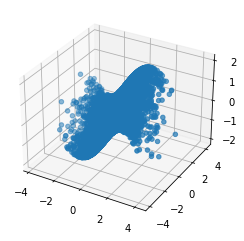

In [3]:
x1, y2, y = make_2d_sine_data(10000)  # Creates dataset with 10000 points

## Interpolation Functions
The following functions define our interpolation through Nearest Neighbors strategy, i.e. each point has its features linearly interpolated with one of its **k-nearest neighbors**.

In [4]:
def get_interpolation_indices(x):
    """Get the indices to interpolate over."""
    knn = NearestNeighbors(n_neighbors=x.shape[0]).fit(x.reshape((-1,1)))
    idxes_A = np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
    idxes_B = [knn.kneighbors(x[idx].reshape((1,-1)), 2, return_distance=False).flatten()[1] for idx in idxes_A]
    return idxes_A, idxes_B

In [5]:
def interpolate_x_and_y(x, y, idxes_A, idxes_B):
    """Interpolates both the x and y values."""
    
    # Generate interpolated points for query
    qx = np.array([np.mean([x[idx_A],x[idx_B]]) for idx_A, idx_B in zip(idxes_A, idxes_B)])
    qy = np.array([np.mean([y[idx_A],y[idx_B]]) for idx_A, idx_B in zip(idxes_A, idxes_B)])
    
    # Test to make sure interpolation works - X (features)
    N = 1
    plt.scatter(np.arange(N), qx[0], color='g', label="Interpolated")
    plt.scatter(np.arange(N), x[idxes_A][0], color='b', label="Random")
    plt.scatter(np.arange(N), x[idxes_B][0], color='r', label="Nearest Neighbor")
    plt.legend()
    plt.title("Interpolation test - X")
    plt.show()
    
    # Test to make sure interpolation works - Y (targets)
    plt.scatter(np.arange(N), qy[0], color='g', label="Interpolated")
    plt.scatter(np.arange(N), y[idxes_A][0], color='b', label="Random")
    plt.scatter(np.arange(N), y[idxes_B][0], color='r', label="Nearest Neighbor")
    plt.legend()
    plt.title("Interpolation test - Y")
    plt.show()
    
    return qx, qy

## Metric Helper Functions
The functions below define how we will compute analytic sine values for evalauting our GPR's ability to interpolate, and the `get_error` function measures the performance of our interpolation relative to the analytic ground truth value.  

The metrics considered are **Mean Absolute Error** (MAE) and **Mean Squared Error** (MSE).

In [6]:
def get_analytic_y(xq, ymean=0):
    """Given query points xq, computes the exact analytic solution of y."""
    return np.sin(xq) + ymean

In [7]:
def get_error(y_true, y_pred):
    abs_errors = np.abs(np.subtract(y_true, y_pred))
    mae = np.mean(abs_errors)
    sq_errors = np.square(np.subtract(y_true, y_pred))
    mse = np.mean(sq_errors)
    print("MAE: {:.3e} \nMSE: {:.3e}".format(mae, mse))
    return mae, mse, abs_errors, sq_errors

In [8]:
def compute_metrics_with_points():
    mses = []
    maes = []
    idxs = []

    for i in range(10, 1000, 100):
        x,y = make_1d_sine_data(i)
        iA, iB = get_interpolation_indices(x)
        qx, qy_interp = interpolate_x_and_y(x, y, iA, iB)
        qy_analytic = get_analytic_y(qx, ymean=0)
        mae, mse, abs_err, sq_err = get_error(qy_analytic, qy_interp)
        maes.append(mae)
        mses.append(mse)
        idxs.append(i)

    plt.plot(idxs, maes)
    plt.title("MAE As a Function of Points with y = sin(x), x ~ N(0,1)")
    plt.xlabel("Number of points")
    plt.ylabel("MAE")
    plt.show()
    plt.plot(idxs, mses)
    plt.title("MSE As a Function of Points with y = sin(x), x ~ N(0,1)")
    plt.xlabel("Number of points")
    plt.ylabel("MSE")
    plt.show()

## Helper Function for Running Pipeline
The function below sets up and runs the functions defined in our pipeline.

In [9]:
def setup(N, xmean, xscale, ymean, new=False):
    x,y = make_1d_sine_data(N, loc=xmean, scale=xscale, loc_y=ymean, new=new)
    iA, iB = get_interpolation_indices(x)
    qx, qy_interp = interpolate_x_and_y(x, y, iA, iB)
    qy_analytic = get_analytic_y(qx, ymean=ymean)
    mae, mse, abs_errors, sq_errors = get_error(qy_analytic, qy_interp)
    return x, y, iA, iB, qx, qy_interp, qy_analytic

## Predict Using GPyTorch
Now that we've set up a pipeline to generate data and generate interpolated test points and their analytic targets, we are now ready to define our GPR model and training routine using `gpytorch`.

### Define GPR Model
Here, we'll use the GPyTorch API to define a Gaussian Process Regression model.  We'll use a `ConstantMean` function $m(x) = c$ for some $c \in \mathbb{R}$, and an outputscaled `MaternKernel` with discontinuity parameter $\nu = \frac{5}{2}$.

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Training + Evaluation Function
The function below follows the standard [GPyTorch documentation tutorial](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html) to run training and evaluation, where the training points are defined to be the points provided initially to the model (upon instantiation), and the test points are provided to the model (after the model is placed in posterior mode) as **interpolated features**.

The GPR model predicts **interpolated targets** from these **interpolated features**, and these predicted interpolated targets are compared to analytic ground truth targets according to the underlying sine function.

In [18]:
def train_and_evaluate(N, xmean, xscale, ymean):
    """Function for getting data, interpolating, and 
    creating + training + evaluating a 1D model."""
    
    # Convert training data to tensors
    x, y, iA, iB, qx, qy_interp, qy_analytic = setup(N, xmean, xscale, ymean)
    train_x = torch.tensor(x).float()
    train_y = torch.tensor(y).float()
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    training_iter = 200

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
    import math
    loss_metric = math.inf
    i = 0
    
    while loss_metric > 0 and i < 1000:
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
        loss_metric = loss.item()
        i += 1
    
    # Ensure model is no longer in training mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.tensor(qx).float()
        f_preds = model(test_x)
        f_mean = f_preds.mean
        
    # Test GP with new points too - sample x from the same underlying distribution
    new_x, new_y_analytic, _, _, _, _, _ = setup(N, xmean, xscale, ymean, new=True)
    new_x_torch = torch.tensor(new_x).float()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        new_f_preds = model(new_x_torch)
        new_f_mean = new_f_preds.mean    
        
    return model, f_mean, qy_interp, qy_analytic, new_y_analytic, new_f_mean

## Putting It All Together
The block below runs our entire pipeline.

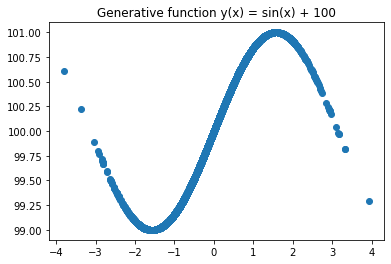

MAE: 1.044e-05 
MSE: 1.449e-07
Iter 1/200 - Loss: 7.623   lengthscale: 0.693   noise: 0.693
Iter 2/200 - Loss: 6.771   lengthscale: 0.744   noise: 0.644
Iter 3/200 - Loss: 6.038   lengthscale: 0.798   noise: 0.600
Iter 4/200 - Loss: 5.406   lengthscale: 0.853   noise: 0.557
Iter 5/200 - Loss: 4.861   lengthscale: 0.909   noise: 0.517
Iter 6/200 - Loss: 4.390   lengthscale: 0.967   noise: 0.478
Iter 7/200 - Loss: 3.981   lengthscale: 1.025   noise: 0.442
Iter 8/200 - Loss: 3.624   lengthscale: 1.084   noise: 0.407
Iter 9/200 - Loss: 3.312   lengthscale: 1.142   noise: 0.374
Iter 10/200 - Loss: 3.036   lengthscale: 1.201   noise: 0.343
Iter 11/200 - Loss: 2.790   lengthscale: 1.258   noise: 0.314
Iter 12/200 - Loss: 2.570   lengthscale: 1.315   noise: 0.287
Iter 13/200 - Loss: 2.372   lengthscale: 1.371   noise: 0.262
Iter 14/200 - Loss: 2.193   lengthscale: 1.426   noise: 0.239
Iter 15/200 - Loss: 2.028   lengthscale: 1.480   noise: 0.217
Iter 16/200 - Loss: 1.877   lengthscale: 1.532  

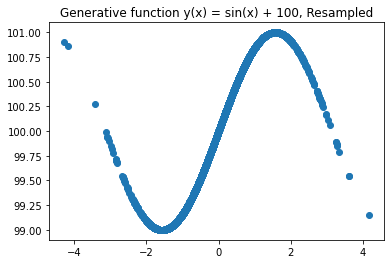

MAE: 2.142e-05 
MSE: 5.105e-07

 GP, INTERPOLATED POINTS:
MAE: 8.883e-03 
MSE: 7.160e-04

 GP, NEWLY-SAMPLED POINTS:
MAE: 1.060e-02 
MSE: 7.095e-03

 LINEAR INTERPOLATION, INTERPOLATED POINTS:
MAE: 1.044e-05 
MSE: 1.449e-07


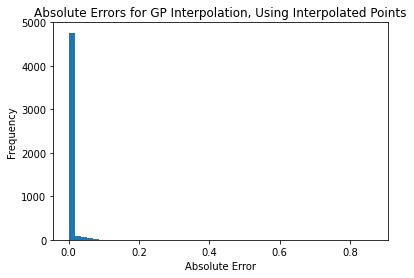

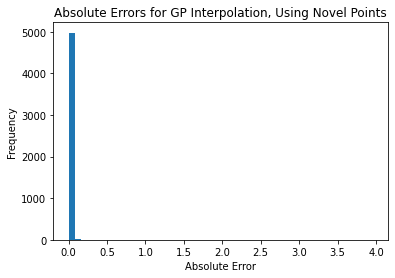

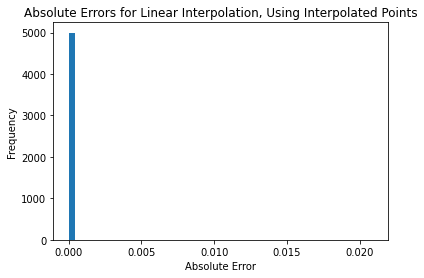

In [24]:
# Get data, create + train + evaluate model, and return predicted/GT values
N = 5000
mu_x = 0
sigma_x = 1
mu_y = 100

# Train and evaluate model
model, qy_gp, qy_interp, qy_analytic, new_y_analytic, new_y_gp = train_and_evaluate(N, mu_x, sigma_x, mu_y)

# Display results
print("\n GP, INTERPOLATED POINTS:")
gp_mae, gp_mse, gp_abs_errors, gp_sq_errors = get_error(qy_analytic, qy_gp.numpy())
print("\n GP, NEWLY-SAMPLED POINTS:")
new_gp_mae, new_gp_mse, new_gp_abs_errors, new_gp_sq_errors = get_error(new_y_analytic, new_y_gp.numpy())
print("\n LINEAR INTERPOLATION, INTERPOLATED POINTS:")
interp_mae, interp_mse, interp_abs_errors, interp_sq_errors = get_error(qy_analytic, qy_interp)

# Save errors to text file
with open("results_N={}_mux={}_sigmax={}_muy={}.txt".format(N, mu_x, sigma_x, mu_y)) as txt_file:
    
# Histogram errors - GP with interpolated points
plt.hist(gp_abs_errors, bins=50)
plt.title("Absolute Errors for GP Interpolation, Using Interpolated Points")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()

# Histogram errors - GP with novel points
plt.hist(new_gp_abs_errors, bins=50)
plt.title("Absolute Errors for GP Interpolation, Using Novel Points")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()

# Histogram errors - Linear Interpolation with interpolated points
plt.hist(interp_abs_errors, bins=50)
plt.title("Absolute Errors for Linear Interpolation, Using Interpolated Points")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()